# What factors lead developers to stay longer in their current jobs ?

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from data_helpers import bucketize_last_hire_date
from data_helpers import transform_coding_experience
from data_helpers import filter_employed_developers

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(color_codes=True)

## Loading data

In [72]:
df = pd.read_csv('data/stackoverflow-2019/survey_results_public.csv')
df.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,28.0,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,5,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,30.0,Man,No,Straight / Heterosexual,White or of European descent;Multiracial,No,Appropriate in length,Easy


In [73]:
df.shape

(88883, 85)

In [74]:
df2 = pd.read_csv('data/stackoverflow-2019/survey_results_schema.csv')
df2.head()

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order ...
1,MainBranch,Which of the following options best describes ...
2,Hobbyist,Do you code as a hobby?
3,OpenSourcer,How often do you contribute to open source?
4,OpenSource,How do you feel about the quality of open sour...


## Part I: Does the job role lead the developers stay longer in the job?

First, we need to find in the data how can we calculate how long each professional stays in a job.

In [75]:
df2[df2.QuestionText == 'When was the last time that you took a job with a new employer?']['Column'].values[0]

'LastHireDate'

In [76]:
df.LastHireDate.value_counts()

Less than a year ago                                    25844
1-2 years ago                                           21365
More than 4 years ago                                   14594
3-4 years ago                                           11597
NA - I am an independent contractor or self employed     3426
I've never had a job                                     3028
Name: LastHireDate, dtype: int64

In [77]:
df2[df2.QuestionText == 'Which of the following best describes your current employment status?']['Column'].values[0]

'Employment'

In [78]:
df.Employment.value_counts()

Employed full-time                                      64440
Independent contractor, freelancer, or self-employed     8511
Not employed, but looking for work                       5600
Employed part-time                                       4469
Not employed, and not looking for work                   3803
Retired                                                   358
Name: Employment, dtype: int64

As we are interested only in analyzing professional who currently work for a employer, we are going to filter other professionals out of our data set.

In [79]:
p1_df = df.copy()
p1_df = filter_employed_developers(p1_df)
p1_df.shape

(68063, 85)

Now, we also have to find how to extract different job titles from the interviewed professionals.

In [80]:
df2[df2.QuestionText == 'Which of the following describe you? Please select all that apply.']['Column'].values[0]

'DevType'

In [81]:
p1_df.DevType.value_counts().head()

Developer, full-stack                                             7550
Developer, back-end                                               4550
Developer, back-end;Developer, front-end;Developer, full-stack    2072
Developer, front-end                                              1961
Developer, mobile                                                 1938
Name: DevType, dtype: int64

We definitely started to understand our data! We have information about how long professionals are in their current jobs and we can analyze it by job role. However, first, we need to transform the data to use it properly.

### Data preparation

First, we need to convert `LastHireDate` to discrete values:

| Answer | Bucket |
| --- | --- |
| Less than a year ago | 1 |
| 1-2 years ago | 2 |
| 3-4 years ago | 3 |
| More than 4 years ago | 4 |


In [82]:
p1_df.loc[:,'YearsInTheJob'] = p1_df['LastHireDate'].apply(bucketize_last_hire_date)
p1_df['YearsInTheJob'].value_counts()

 1    22378
 2    19080
 4    13453
 3    10531
-1     2621
Name: YearsInTheJob, dtype: int64

Then, we need to clean `DevType`. As a professional can have multiple job roles and we are interested in analyzing `YearsInTheJob` per job role, we will attribute `YearsInTheJob` to each job role defined by the professional.

In [83]:
p1_df.loc[:,'JobRole'] = p1_df['DevType'].apply(lambda x: str(x).split(';'))
p1_df = p1_df.explode('JobRole')
p1_df = p1_df[p1_df.JobRole != 'nan']
p1_df[['JobRole', 'YearsInTheJob']].head()

,JobRole,YearsInTheJob
2,Designer,2
2,"Developer, back-end",2
2,"Developer, front-end",2
2,"Developer, full-stack",2
3,"Developer, full-stack",1


Let's also prepared `YearsCode` variable:

In [84]:
p1_df['YearsCodePro'] = p1_df['YearsCodePro'].fillna(value=-1)
p1_df.loc[:,'YearsCodePro'] = p1_df['YearsCodePro'].apply(transform_coding_experience)

### Answering the question

For each job role, we want to know what is the most frequent `YearsInTheJob` value. As `YearsInTheJob` is not continuous, we will use the `mode` of this variable.

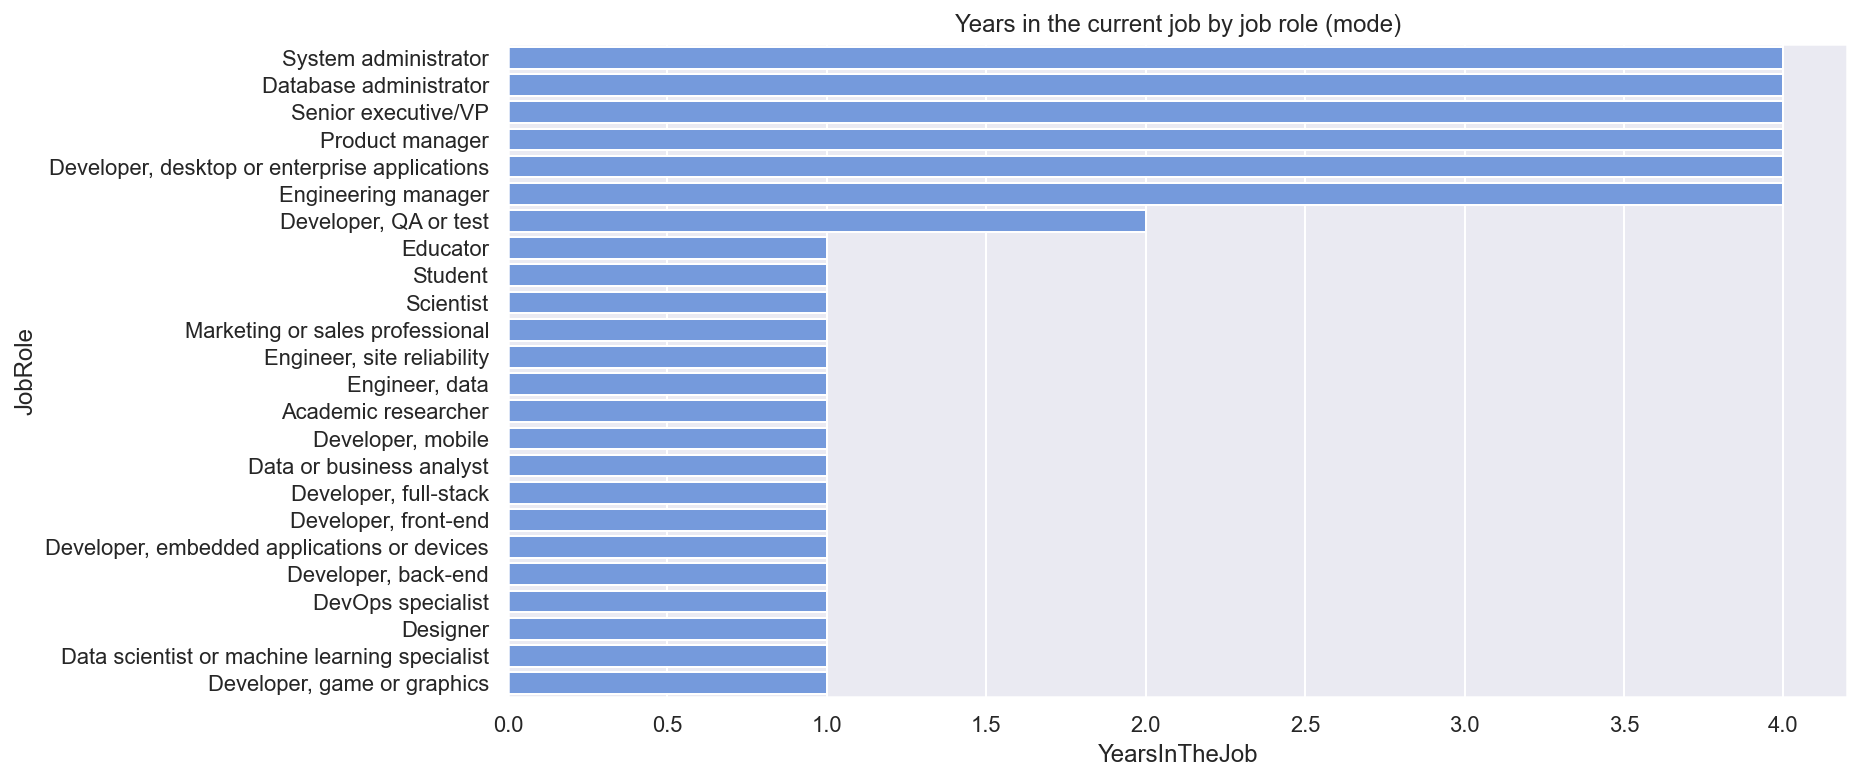

In [95]:
agg_p1_df = p1_df.groupby(['JobRole']).agg({'YearsInTheJob': lambda x: x.value_counts().index[0]})\
                 .sort_values(by='YearsInTheJob', ascending=False)\
                 .reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='YearsInTheJob', y='JobRole', orient='h', data=agg_p1_df, color='cornflowerblue');
plt.title('Years in the current job by job role (mode)');

#### Conclusions

* There are 6 job roles where most of professionals are 4 years or more in their current jobs:

  * System administrator
  * Database administrator
  * Senior executive/VP
  * Product manager
  * Engineering manager
  * Developer, desktop or enterprise applications


* It seems professionals working in management positions stay longer in their jobs. A hypothesis is those professionals developed their entire careers in the same company. That is something we will investigate in the second part of this analysis. The only exception in this pattern is `Developer, desktop or enterprise applications`.


* We can also observe the mode for `Developer QA or test` is higher than for the other developers.



Regarding the remaining job roles, we observe turn-over may be high as mostly of the interviewed professionals are less than 1 year in their jobs. Or maybe these professionals may be in the beginning of their careers. Let's drill our analysis down in more variables for each job role. Let's get started by years coding (experience).

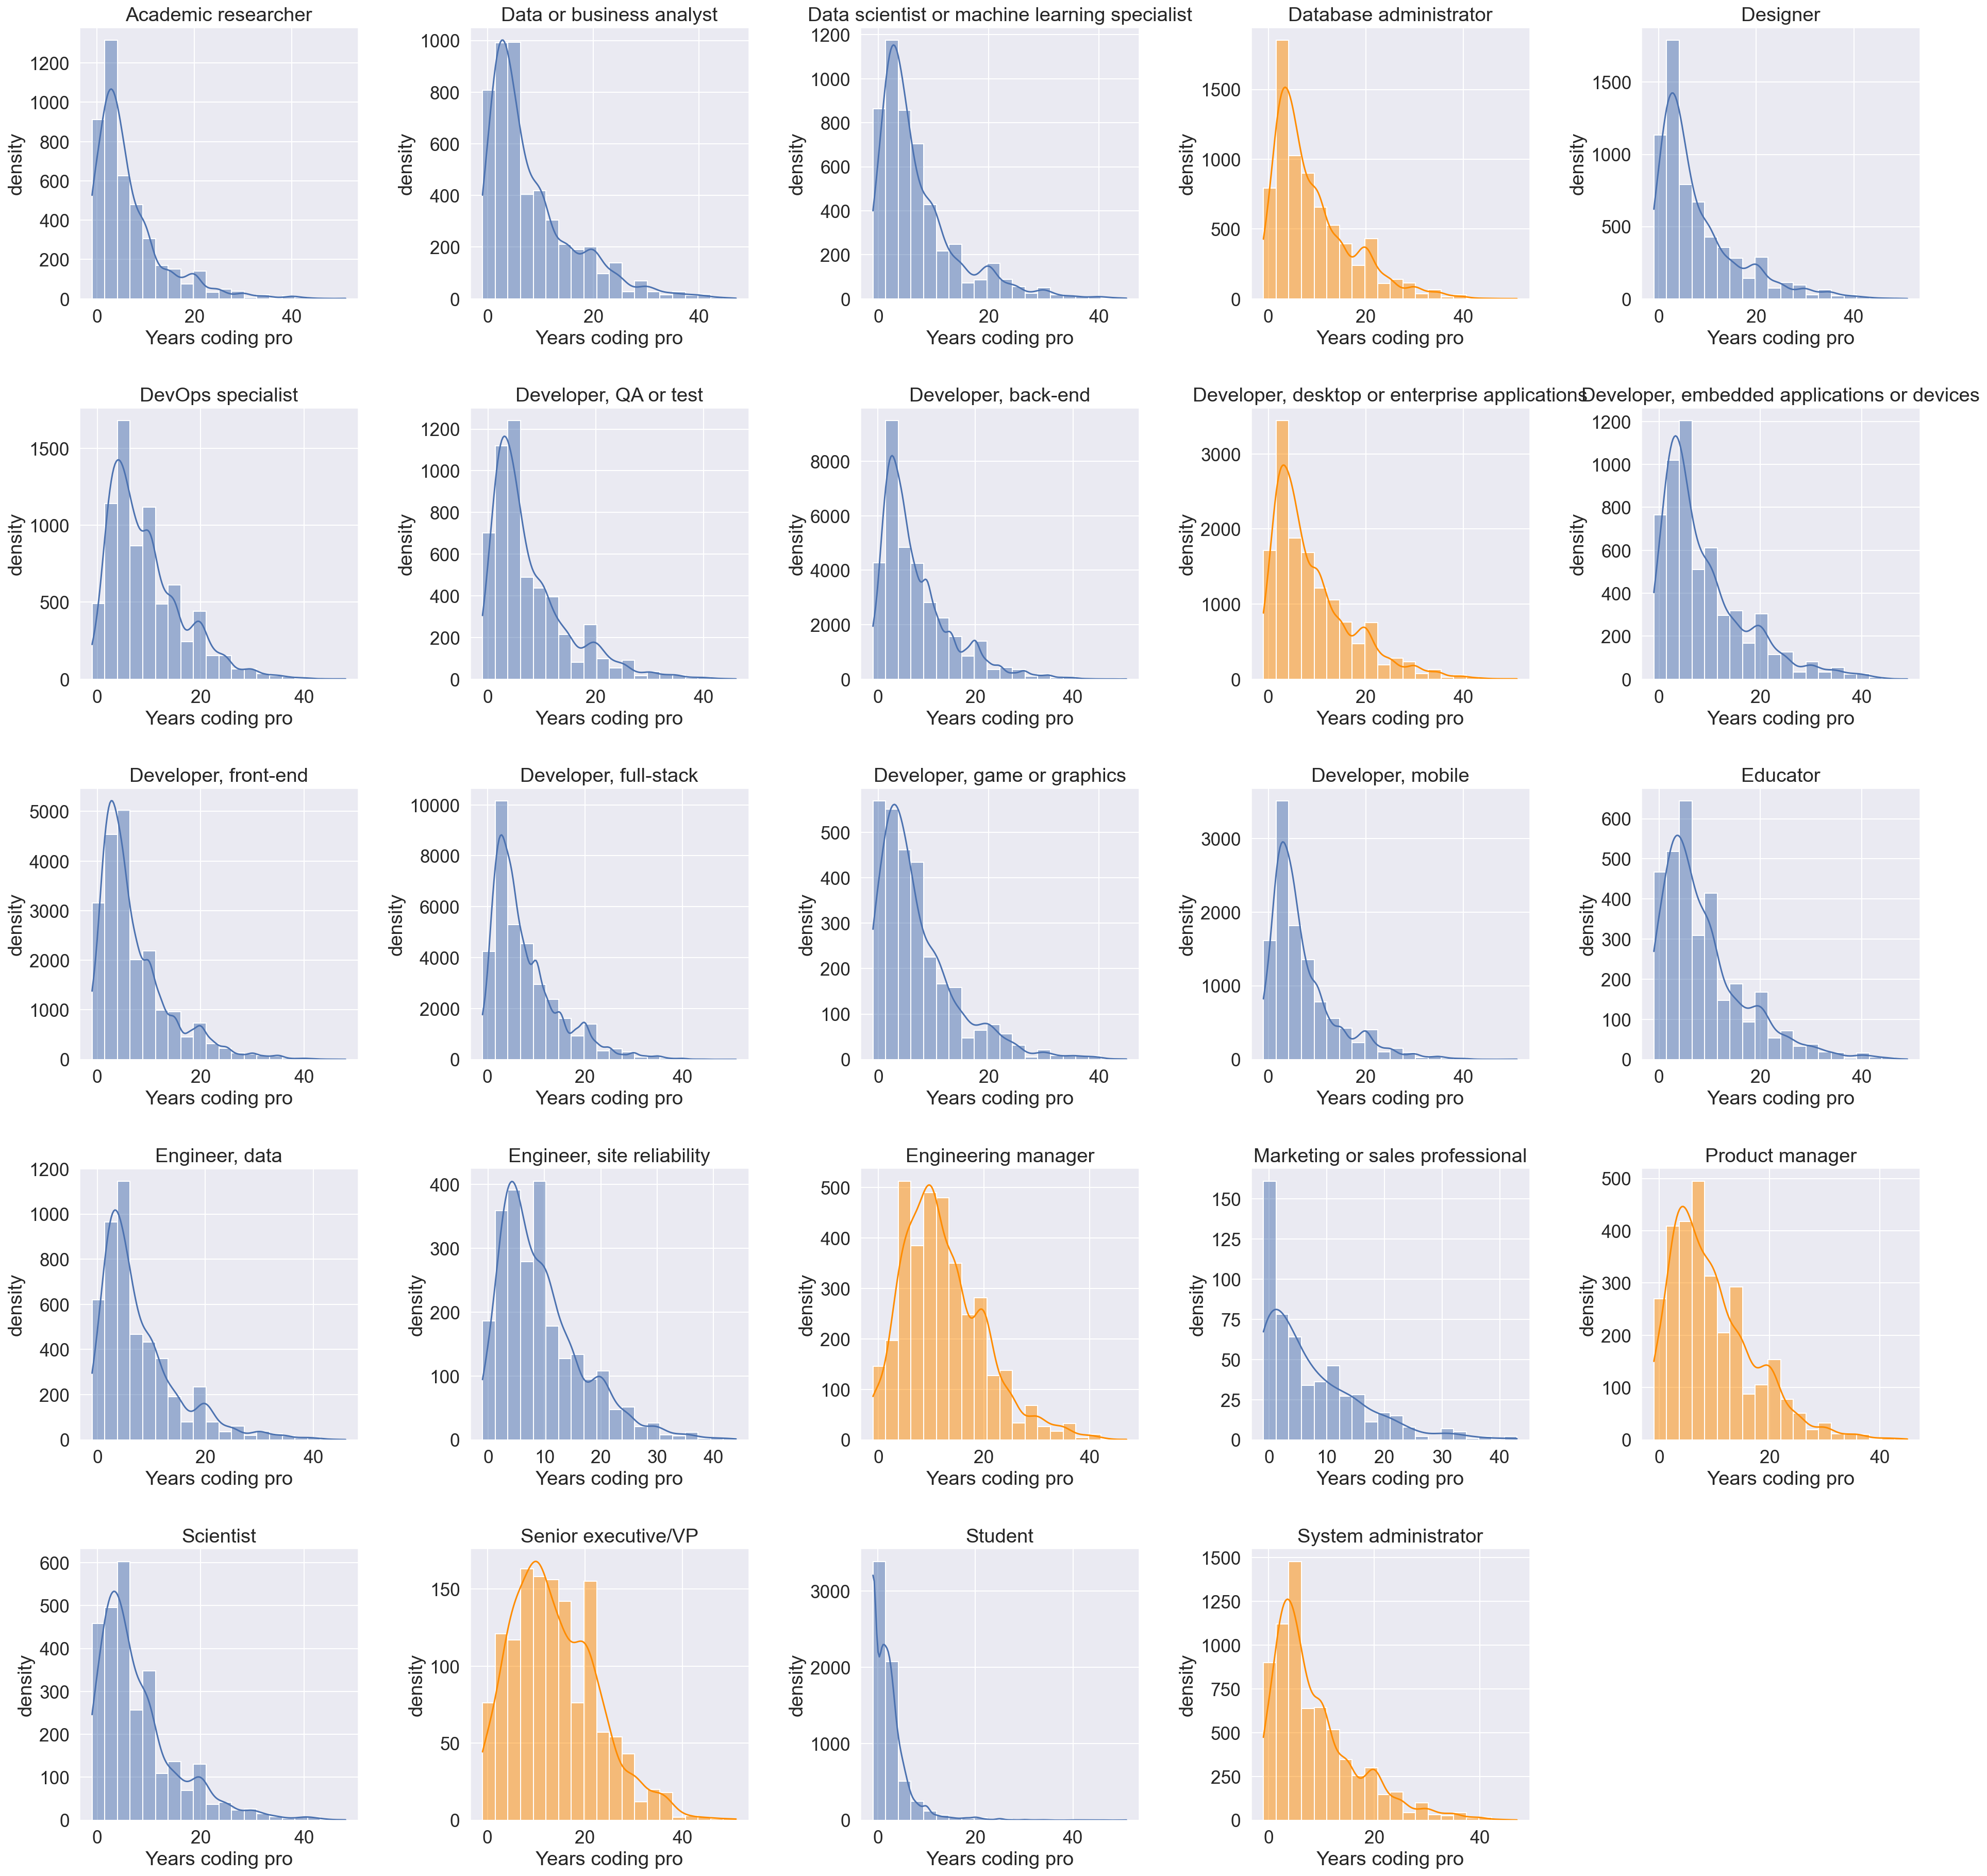

In [86]:
sns.set(font_scale=1.6)

job_roles = sorted(agg_p1_df.JobRole.unique())

fig = plt.figure(figsize=(32, 32))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

top_roles = ['System administrator', 'Database administrator', 'Senior executive/VP', 'Product manager', 
             'Engineering manager', 'Developer, desktop or enterprise applications']

for idx, job_role in enumerate(job_roles):
    ax = fig.add_subplot(5, 5, idx + 1)
    
    data = p1_df[p1_df.JobRole == job_role][['YearsCodePro']]
    
    if job_role in top_roles:
        sns.histplot(data=data, bins=20, ax=ax, x='YearsCodePro', color='darkorange', kde=True)
    else:
        sns.histplot(data=data, bins=20, ax=ax, x='YearsCodePro', kde=True)
      
    ax.set(xlabel='Years coding pro', ylabel='density')
    ax.set_title(job_role)
    
plt.show();

sns.set(font_scale=1)

#### Conclusions

* `YearsCoding` distribution is very similar for job roles where most of professionals are **less than 1 year** in their jobs.
* For professionals who are longer in their jobs (orange plots), we can observe, for management roles, the interviewed professionals are more experienced.

## Part II: Wishing to become a manager leads developers stay longer in a job ?

In [87]:
df2[df2.QuestionText == 'Do you want to become a manager yourself in the future?']['Column'].values[0]

'MgrWant'

In [88]:
p1_df['MgrWant'].value_counts()

Not sure                  60504
No                        54326
Yes                       44987
I am already a manager     9434
Name: MgrWant, dtype: int64

In [89]:
manager_df = p1_df[p1_df['MgrWant'].isin(['Yes'])].groupby(['JobRole']).size() / p1_df.groupby(['JobRole']).size()
manager_df.sort_values(ascending=False).head()

JobRole
Developer, mobile                  0.284702
Designer                           0.276505
Data or business analyst           0.269758
Academic researcher                0.261189
Marketing or sales professional    0.250000
dtype: float64

We can observe, professionals who are `Developer mobile`, `Designer`, `Data or business analyst`, `Academic researcher` or `Marketing or sales professional` are more willing to become a manager. Let's check weather they are more willing to stay longer in their current jobs.

Let's get started by filtering our current result set by professionals who currently are not a manager but wish to become one.

In [90]:
p2_df = p1_df[(p1_df.MgrWant == 'Yes') &
              (~p1_df.JobRole.isin(['Senior executive/VP', 'Product manager', 'Engineering manager']))
]

p2_df.shape

(44343, 87)

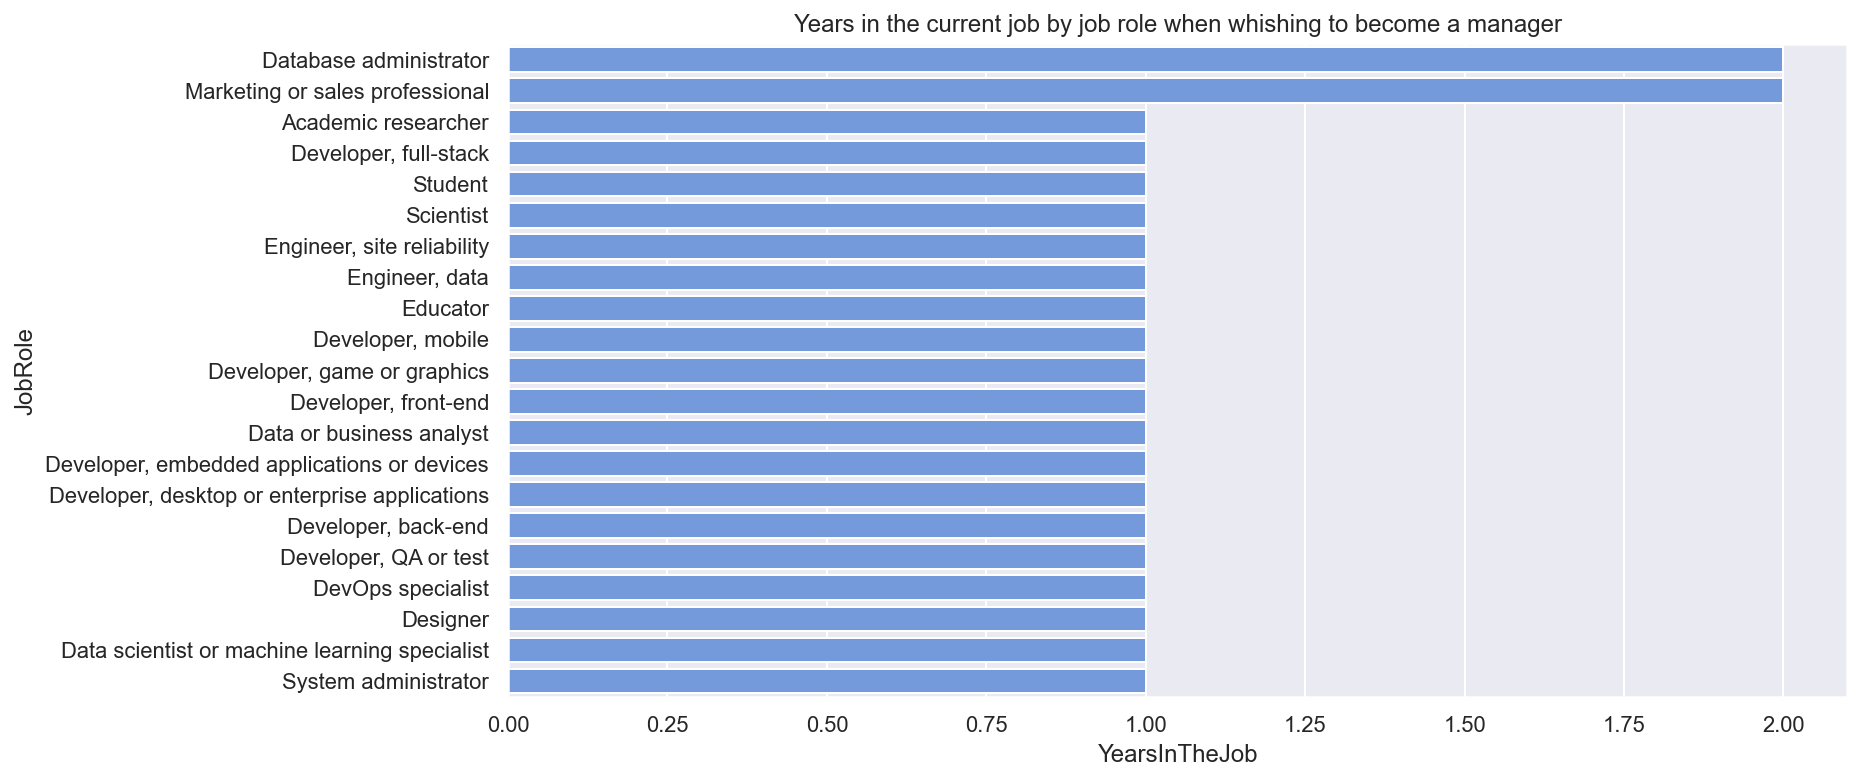

In [91]:
agg_p2_df = p2_df.groupby(['JobRole']).agg({'YearsInTheJob': lambda x: x.value_counts().index[0]})\
                 .sort_values(by='YearsInTheJob', ascending=False)\
                 .reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='YearsInTheJob', y='JobRole', orient='h', data=agg_p2_df, color='cornflowerblue');
plt.title('Years in the current job by job role when whishing to become a manager');

#### Conclusions

It seems that wishing to become a manager in the future does not make professionals stay longer in their current jobs. The mode for most of professionals also concentrate in 1 (**less than 1 year**). Maybe it changes for experienced professionals. Let's analyze professionals with at least 10 years of experience.

In [92]:
df2[df2.QuestionText == 'How many years have you coded professionally (as a part of your work)?']['Column'].values[0]

'YearsCodePro'

In [93]:
p2a_df = p2_df[p2_df.YearsCodePro >= 10]
p2a_df.shape

(7954, 87)

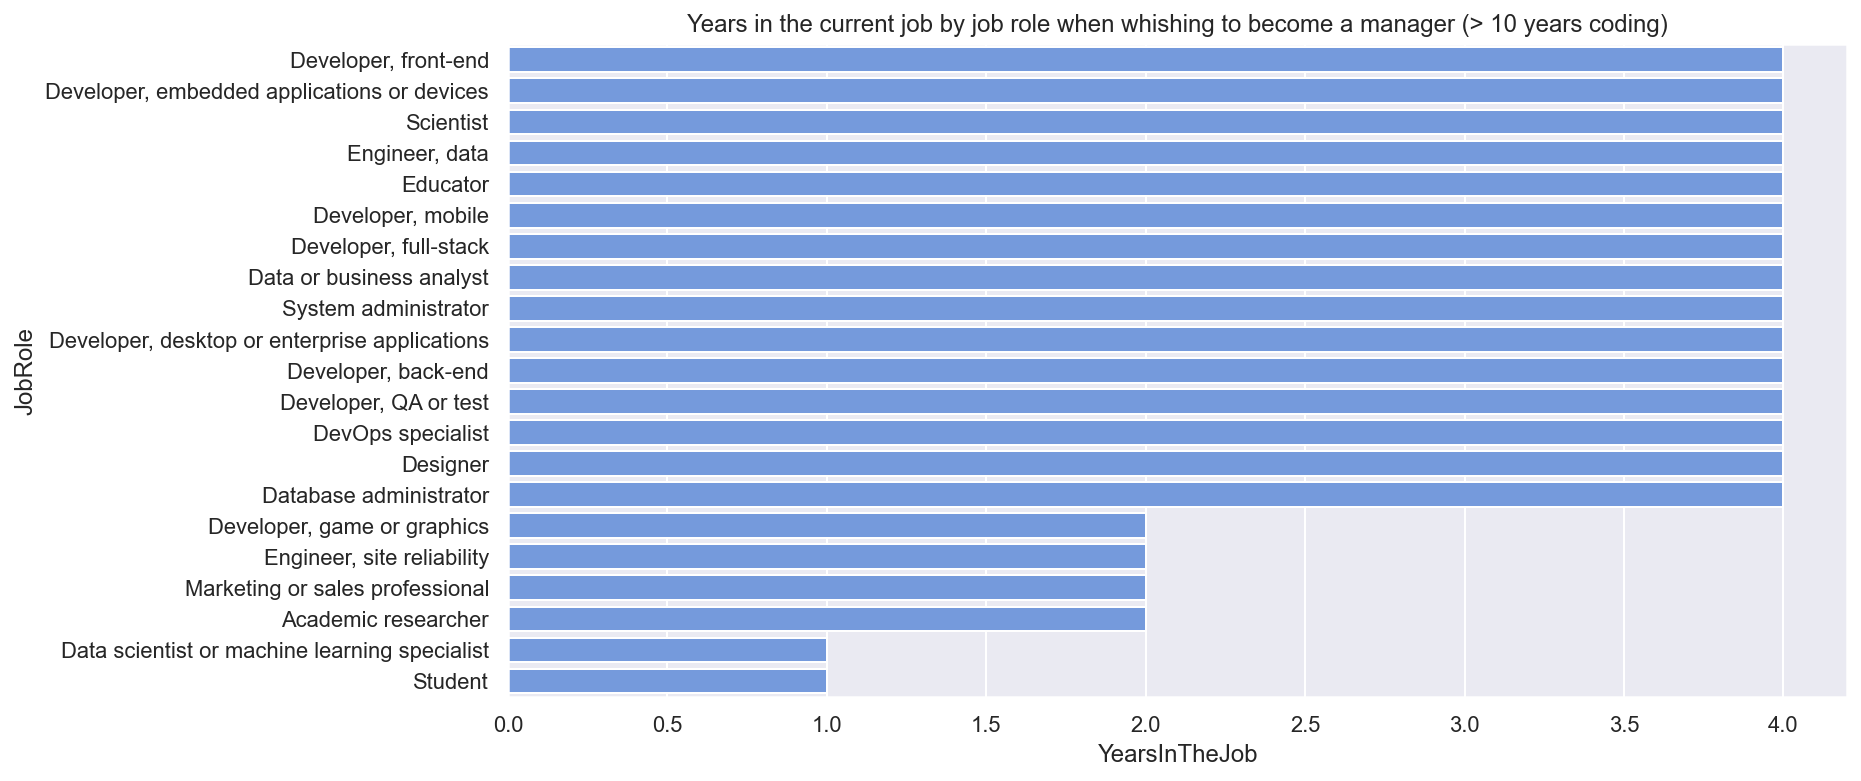

In [94]:
agg_p2a_df = p2a_df.groupby(['JobRole']).agg({'YearsInTheJob': lambda x: x.value_counts().index[0]})\
                 .sort_values(by='YearsInTheJob', ascending=False)\
                 .reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='YearsInTheJob', y='JobRole', orient='h', data=agg_p2a_df, color='cornflowerblue');
plt.title('Years in the current job by job role when whishing to become a manager (> 10 years coding)');

#### Conclusions

Based on the last plot, the data suggest our hypothesis is promising. Most of the pore experienced developers who wish to become a manager in the future are longer in their current jobs!